# Replication: Shu *et al*, 2020
## Introduction

This notebook attempts to replicate the following paper with the [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study recruited 72 patients with progressive PD and 72 patients with stable PD matched by age, sex and category of HYS. The objective of the study is to develop and validate a radiomics model to predict the progression of Parkinson disease. This following population from PPMI was used:

<img src="./images/table.png" width="80%"/>

Shu et al. report an AUC of 0.795 for their radiomics model. This suggests that the a radiomics signature model from whole-brain white matter can be a useful tool for the assessment and monitoring of PD progression.

<img src="./images/result.png" width="30%"/>

The remainder of this notebook is an attempt to replicate this result using the PPMI dataset.

## Content

<br>
<details>
    <summary><b>&rarr; Click me</b> to open table</summary>
    
**[Initial setup](#Initial-setup)**

  * [1.1. Cohort selection](#Cohort-selection)
  * [1.2. Matching](#Matching)
  * [1.3. Cohort summary](#Cohort-summary)

**[2. Feature extraction](#Feature-extraction)**

  * [2.1. White Matter mask extraction using SPM12](#White-Matter-mask-extraction-using-SPM12)
  * [2.2. Quality control](#Quality-control)
  * [2.3. Radiomic features](#Radiomic-features)
  * [2.4. ROI features](#ROI-features)
    
**[3. Feature selection](#Feature-selection)**

  * [3.1. rMRMe using R](#rMRMe-using-R)
  * [3.2. Original features used in Shu et al.](#Original-features-used-in-Shu-et-al.)

**[4. Machine Learning](#Machine-Learning)**
  * [4.1. Normalization](#normalization)
  * [4.2. Select features](#Select-features)
  * [4.3. Model training](#Model-training)
      * [4.4.1 Model training using Scikit-Learn](#Model-training-using-Scikit-Learn)  
  * [4.4. Performance](#Performance)

**[5. Feature analysis](#Feature-analysis)**
    
</details>

## Initial setup

Let's initialize the notebook dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils('shu-etal')
utils.notebook_init()

removing link inputs
removing link outputs
This notebook was run on 2023-02-01 02:40:28 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 
* Age at visit (this could also be retrieved from imaging data)
* Demographics (to retrieve sex)
* Participant Status (to retrieve PD patients)

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [2]:
required_files = [
    'Age_at_visit.csv', 
    'Demographics.csv', 
    'Participant_Status.csv'
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


### Additional data

We will also need the `MRI_info.csv` ([available here](https://github.com/LivingPark-MRI/livingpark-utils/blob/main/livingpark_utils/notebooks/mri_metadata.ipynb)) and `MDS_UPDRS_Part_III_clean.csv` ([available here](https://github.com/LivingPark-MRI/livingpark-utils/blob/main/livingpark_utils/notebooks/pd_status.ipynb)) that are produced by another LivingPark notebook available.

The `MRI_info.csv` file contains a list usable T1-weighted MRIs. This is important since the original study uses  T1-weighted MRIs from PPMI. Therefore, we need to filter out all other scanners. The `MDS_UPDRS_Part_III_clean.csv` file is a refined version of PPMI's UPDRS III data.

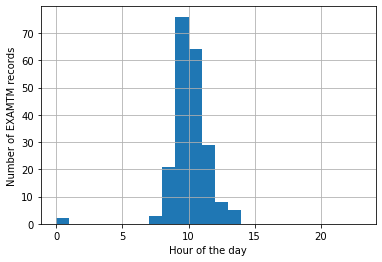

In [3]:
from livingpark_utils.scripts import run

run.mri_metadata()
run.pd_status()

## Hoehn & Yahr stage

We will use the `MDS_UPDRS_Part_III_clean.csv` study file to get patients that are ON or OFF functional state.

In [4]:
import os
import pandas as pd

# Define data directory for additional data
data_dir = "data"

# Load PPMI UPDRS III data (modified)
df_hy = pd.read_csv(
    os.path.join(data_dir, 'MDS_UPDRS_Part_III_clean.csv')
)

# Drop unnecessary columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Display number of patients
df_hy.groupby('PDSTATE').count()

,PATNO,EVENT_ID,NHY,PDTRTMNT
PDSTATE,,,,
OFF,12979,12979,12972,12979
ON,5666,5666,5663,5666


We observe that about 70% of patients' functional state is in the OFF state.

## Demographics

Needed for sex. (0: Female, 1: Male)

In [5]:
# Load PPMI Demographics data
demo = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Demographics.csv')
)

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

# Convert data to 0/1 values
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,993
1,1350


There is a fair balance between the number of males and females.

## Age at visit

Needed for age.

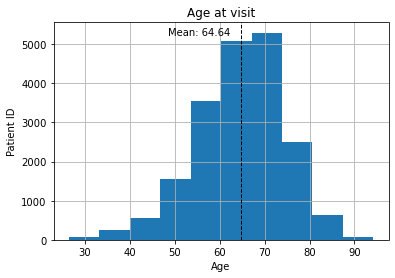

In [6]:
import matplotlib.pyplot as plt

# Load PPMI age data
df_age = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Age_at_visit.csv')
)

# Show histogram
df_age['AGE_AT_VISIT'].hist()

# Histogram settings
plt.title('Age at visit')
plt.xlabel('Age')
plt.ylabel('Patient ID');
plt.axvline(df_age['AGE_AT_VISIT'].mean(), color='k', linestyle='dashed', linewidth=1);
min_ylim, max_ylim = plt.ylim()
plt.text(df_age['AGE_AT_VISIT'].mean()*0.75, max_ylim*0.94, 'Mean: {:.2f}'.format(df_age['AGE_AT_VISIT'].mean()));

Our histogram suggests that the majority of patients are between the ages of 60 and 72 with the mean sitting around 64 years old.

### Cohort selection

We will build three cohorts in total. Below is a description of each. Make sure you select the cohort you'd like to use for the rest of the notebook.

|     **Cohort Type**     |                                          **Description**                                          |
|:-----------------------:|:-------------------------------------------------------------------------------------------------:|
| Reference Cohort        | Patients in this cohort have a 3T T1-weighted MRI image scanned with a Siemens MRI machine.       |
| Multiple 3T Scanner Cohort | Patients in this cohort have a 3D T1-weighted MRI image scanned with **any** MRI machine. |
| PD-state cohort | Patients in this cohort have a 3D T1-weighted MRI image scanned with **any** MRI machine and PDSTATUS matched across visits. |
| No Filter Cohort | Patients in this cohort have a 3D MRI image scanned with **any** MRI machine with slice thickess between 1mm and 1.2mm. |

**NOTE: If this step is not completed, we will built the Reference Cohort by default**

In [7]:
import ipywidgets as widgets
from IPython.display import display

questions=widgets.RadioButtons(
    options=['Reference Cohort', 'Multiple 3T Scanner Cohort', 'PD-state Cohort', 'No Filter Cohort'],
    value=None,
    description='Select cohort:',
    disabled=False)

def cohort_prompt(sender): 
    COHORT_TYPE = questions.value
    print('Selected cohort: ' + COHORT_TYPE)
        
questions.observe(cohort_prompt, names=['value'])
questions

RadioButtons(description='Select cohort:', options=('Reference Cohort', 'Multiple 3T Scanner Cohort', 'PD-stat…

Selected cohort: Reference Cohort


## MRI availability

Shu et al.'s cohort concists of patients evaluted over the course of 3 years and classifies the patients into progressive and stable groups. The `MRI_info.csv` has clinical data on every patient and every single visit. We will keep patients that

1. Have a pair of visits spaced 3 years apart
2. Have an MRI scan with slice thickness = 1.0 mm
3. Have an MRI scan with field strength = 3T

In [8]:
import numpy as np

# Set cohort type
COHORT_TYPE = "Reference Cohort" if questions.value is None else questions.value

# Read MRI_Info
mri_df = pd.read_csv(
    os.path.join(utils.study_files_dir, 'MRI_info.csv')
)

# Pair of visits to keep
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}

# Split string into columns
mri_df[['Acquisition Plane', 'Field Strength', 'Manufacturer', 'Slice Thickness']] = mri_df["Imaging Protocol"].apply(lambda x: pd.Series(str(x).split(";")))

# Keep columns needed + filter for MRI scan measurements
if COHORT_TYPE=="Reference Cohort" or COHORT_TYPE=="Multiple 3T Scanner Cohort" or COHORT_TYPE=="PD-state Cohort":
    mri_df=mri_df[
        (mri_df["Field Strength"]=="Field Strength=3.0") 
        & (mri_df["Slice Thickness"]=="Slice Thickness=1.0")
    ][["Subject ID", "Sex", "Visit code", "Age", "Description", "Manufacturer", "Slice Thickness", "Field Strength"]]

elif COHORT_TYPE=="No Filter Cohort":
    mri_df=mri_df[
        ((mri_df["Slice Thickness"]=="Slice Thickness=1.0") |(mri_df["Slice Thickness"]=="Slice Thickness=1.2"))
    ][["Subject ID", "Sex", "Visit code", "Age", "Description", "Manufacturer", "Slice Thickness", "Field Strength"]]
    
# Keep visit pairs
mri_df.rename(columns={'Subject ID': 'PATNO', 'Visit code': 'EVENT_ID', "Manufacturer": "Imaging Protocol"}, inplace=True)
mri_df = mri_df[mri_df['EVENT_ID'].isin(visits)]

# Replace string values
mri_df["Imaging Protocol"] = mri_df["Imaging Protocol"].map(lambda x: x[13:])
mri_df["Slice Thickness"] = mri_df["Slice Thickness"].map(lambda x: float(x[16:]))
mri_df["Field Strength"] = mri_df["Field Strength"].map(lambda x: float(x[15:]))

mri_df.groupby("EVENT_ID").count()

,PATNO,Sex,Age,Description,Imaging Protocol,Slice Thickness,Field Strength
EVENT_ID,,,,,,,
BL,655,655,655,655,655,655,655
V04,273,273,273,273,273,273,273
V06,256,256,256,256,256,256,256
V08,2,2,2,2,2,2,2
V10,249,249,249,249,249,249,249


## Participant status

Keep patients with PD.

In [9]:
# Read CSV | 1: PD, 2: Cohort
participant_df = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Participant_Status.csv')
)

# Keep useful columns
participant_df = participant_df[["PATNO", "COHORT_DEFINITION"]]
participant_df = participant_df[participant_df["COHORT_DEFINITION"]=="Parkinson's Disease"]

# Display stats
participant_df.groupby('COHORT_DEFINITION').count()

,PATNO
COHORT_DEFINITION,
Parkinson's Disease,1153


## Merge all dataframes together

Before performing cohort matching, we need to build one final dataframe that consists of all the data we just extracted.

In [10]:
df_mri_age = df_age.merge(mri_df, how='right')
df_mri_age['AGE_AT_VISIT'].fillna(df_mri_age['Age'])
df_mri_age = df_mri_age.merge(participant_df, on="PATNO")

df = df_hy.merge(df_mri_age, how='inner')

if COHORT_TYPE == "Reference Cohort":
    df = df[
        (df["Imaging Protocol"] == "SIEMENS") | 
        (df["Imaging Protocol"] == "Siemens")
    ]
    
# Display patients per HY stage
df.groupby('NHY').count()

,PATNO,EVENT_ID,PDSTATE,PDTRTMNT,AGE_AT_VISIT,Sex,Age,Description,Imaging Protocol,Slice Thickness,Field Strength,COHORT_DEFINITION
NHY,,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2,2
1,227,227,227,227,227,227,227,227,227,227,227,227
2,660,660,660,660,660,660,660,660,660,660,660,660
3,38,38,38,38,38,38,38,38,38,38,38,38
4,7,7,7,7,7,7,7,7,7,7,7,7


## Format data by visit pairs

Finally, we form the data such that each row contains a patients' data from both visits.

In [11]:
def next_visit(x):
    '''
    Returns the next visit (3y) after baseline visit.
    '''
    
    return visits[x]

def save_exclusions(exclude):
    '''
    Saves the patients to exclude in case errors occur.
    
    exclude: list
        List of subject IDs to exclude
    '''
    
    with open('exclusions.csv', 'w') as f:
        for index, subId in enumerate(exclude):
            f.write(str(subId))
            if index!=len(exclude)-1:
                f.write('\n')
        
def open_exclusions() -> list:
    '''
    Opens the list of exclusions in a set.
    '''
    
    exclude = []
    if os.path.exists('exclusions.csv'):
        with open('exclusions.csv', 'r') as f:
            for sub in f:
                exclude.append(sub)
    return exclude

def build_visit_df():
    visits_df = df
    
    # Exclude patients (if applicable)
    exclude_patients = open_exclusions()
    if len(exclude_patients) > 0:
        for patient in exclude_patients:
            patient = patient.replace("\n", "")
            subId = int(patient.split("|")[0])
            visitId = patient.split("|")[1]
            indexes = visits_df[(visits_df["PATNO"]==subId) & (visits_df["EVENT_ID"]==visitId)].index
            visits_df = visits_df.drop(indexes)

    # Set id of second visit in pair
    visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

    # Retrieve H&Y score of next visit
    visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

    # Add patient sex to visit pairs
    visits_df = visits_df.merge(demo, on=['PATNO'])

    # Define visit as stable if NHY (first visit)
    visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

    if COHORT_TYPE == "PD-state Cohort":
        # Keep visit pairs with same PDSTATUS
        visits_df = visits_df[visits_df["PDSTATE_x"]==visits_df["PDSTATE_y"]]

    # Display data pairs
    visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()
    
    return visits_df

visits_df = build_visit_df()
visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  AGE_AT_VISIT  Sex  \
stable NHY_x                                                                
False  0          3           3          3           3             3    3   
       1        243         243        243         243           243  243   
       2        321         321        321         321           321  321   
       3         41          41         41          41            41   41   
       4          8           8          8           8             8    8   
True   1         99          99         99          99            99   99   
       2        613         613        613         613           613  613   
       3          3           3          3           3             3    3   
       4          1           1          1           1             1    1   

              Age  Description  Imaging Protocol  Slice Thickness  \
stable NHY_x                                                        
False  0        3            3                 3                3   
       1      243          243               243              243   
       2      321          321               321              321   
       3       41           41                41               41   
       4        8            8                 8                8   
True   1       99           99                99               99   
       2      613          613               613              613   
       3        3            3                 3                3   
       4        1            1                 1                1   

              Field Strength  COHORT_DEFINITION  next_visit  EVENT_ID_y  \
stable NHY_x                                                              
False  0                   3                  3           3           2   
       1                 243                243         243         210   
       2                 321                321         321         125   
       3                  41                 41          41          15   
       4                   8                  8           8           4   
True   1                  99                 99          99          99   
       2                 613                613         613         613   
       3                   3                  3           3           3   
       4                   1                  1           1           1   

              PDSTATE_y  NHY_y  PDTRTMNT_y  SEX  
stable NHY_x                                     
False  0              2      2           2    3  
       1            210    210         210  243  
       2            125    125         125  321  
       3             15     15          15   41  
       4              4      4           4    8  
True   1             99     99          99   99  
       2            613    613         613  613  
       3              3      3           3    3  
       4              1      1           1    1

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [12]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,AGE_AT_VISIT,Age,Slice Thickness,Field Strength,PDTRTMNT_y,SEX,AGE_AT_VISIT_norm
count,1332.000000,1332.000000,1332.000000,1332.000000,1332.0,1332.0,1072.000000,1332.000000,1.332000e+03
mean,15740.828078,0.726727,63.004655,63.011036,1.0,3.0,0.979478,0.662162,-2.526574e-14
std,25830.336324,0.445807,9.437353,9.428725,0.0,0.0,0.141845,0.473151,1.000000e+00
min,3102.000000,0.000000,38.000000,38.000000,1.0,3.0,0.000000,0.000000,-2.649541e+00
25%,3325.000000,0.000000,55.575000,55.575000,1.0,3.0,1.000000,0.000000,-7.872604e-01
50%,3776.000000,1.000000,64.100000,64.200000,1.0,3.0,1.000000,1.000000,1.160649e-01
75%,4081.000000,1.000000,70.525000,70.600000,1.0,3.0,1.000000,1.000000,7.968702e-01
max,158117.000000,1.000000,86.300000,86.300000,1.0,3.0,1.000000,1.000000,2.468419e+00


## Matching loop implementation

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [13]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = sorted(pd.unique(group1_df['PATNO']))
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)

    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

### Match patients based on age, sex and H&Y score

In [14]:
matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# Apply matching to get 47 patients with H&Y=1
stable1, progr1 = match(32,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)
patids = pd.unique(pd.concat([stable1, progr1], axis=0)["PATNO"])
df_filtered = df[~df['PATNO'].isin(patids)]

# Apply matching to get 25 patients with H&Y=2
stable2, progr2 = match(40,
                        df_filtered[(df_filtered['stable'] == True) & (df_filtered['NHY_x'] == "2")],
                        df_filtered[(df_filtered['stable'] == False) & (df_filtered['NHY_x'] == "2")],
                        matched_vars)

stable = stable1.append(stable2)
progr = progr1.append(progr2)

## Sanity checks

In order to ensure that the cohort built meets the requirements, we ensure that:

1. Both groups have equal size

2. No patient is present more than once in each group

3. Patients in group A aren't in group B and vice versa

In [15]:
def sanityCheck(stable1, progr1, stable2, progr2):
    for (a, b) in [(stable1, progr1), (stable2, progr2)]:
        # Both groups have equal size
        assert(len(a) == len(b))
        # No patient is present more than once in each group
        for x in [a, b]:
            patnos_x = pd.unique(x['PATNO'])
            assert(len(patnos_x)==len(x)), x
        # Patients in a aren't in b
        patnos_a = pd.unique(a['PATNO'])
        patnos_b = pd.unique(b['PATNO'])
        for p in patnos_a:
            assert(p not in patnos_b), f'PATNO {p} appears in a and b'

    # Patients in each cohort do not replicate
    assert len(set(pd.unique(progr["PATNO"])) & (set(pd.unique(stable["PATNO"]))))==0, "Patients occur in both groups"

    print('All good!')
    
sanityCheck(stable1, progr1, stable2, progr2)

All good!


## Cohort summary

In [16]:
from scipy import stats

def summary(stable, progr):
    cohort_stats = pd.DataFrame(columns=[f"Stable", f"Progression", "P-Value"])

    cohort_stats.loc["Subjects, No."] = [len(stable), len(progr), "N/a"]

    cohort_stats.loc["F/M, No."] = [
        f"{len(stable[stable['SEX']==0])}/{len(stable[stable['SEX']==1])}",
        f"{len(progr[progr['SEX']==0])}/{len(progr[progr['SEX']==1])}",
        f"{stats.ttest_ind(list(stable['SEX']), list(progr['SEX'])).pvalue}"
    ]

    cohort_stats.loc["Age, mean +/- SD"] = [
        f"{round(stable['Age'].mean(),1)} +/- {round(stable['Age'].std(),1)}",
        f"{round(progr['Age'].mean(),1)} +/- {round(progr['Age'].std(),1)}",
        f"{stats.ttest_ind(list(stable['Age']), list(progr['Age'])).pvalue}"
    ]

    cohort_stats.loc["Hoehn & Yahr Stage 1 (n)"] = [
        f"{len(stable[stable['NHY_x']=='1'])}",
        f"{len(progr[progr['NHY_x']=='1'])}",
        "1.0"
    ]

    cohort_stats.loc["Hoehn & Yahr Stage 2 (n)"] = [
        f"{len(stable[stable['NHY_x']=='2'])}",
        f"{len(progr[progr['NHY_x']=='2'])}",
        "1.0"
    ]

    return cohort_stats

summary(stable, progr)

,Stable,Progression,P-Value
"Subjects, No.",72,72,N/a
"F/M, No.",29/43,29/43,1.0
"Age, mean +/- SD",61.0 +/- 8.8,61.1 +/- 8.6,0.9291174059607847
Hoehn & Yahr Stage 1 (n),32,32,1.0
Hoehn & Yahr Stage 2 (n),40,40,1.0


### Why can't we replicate Shu et al.'s cohort?

The above cohort is the closest we could build according to the filters used in Shu et al. We are able to construct a cohort of n=144, however, the distribution of patients with baseline H&Y=1 and 2 are not the same. Shu et al. has 47 patients with H&Y stage 1 and 25 patients with H&Y stage 2. 

We believe we could not exactly replicate the cohort used by Shu et al. since there could be patients in their cohort that withdrew from the study. 

# Feature extraction

In this section, we will use our cohort to extract two sets of features: **radiomics features** & **ROI features**.

First, we will build the `cohort` dataframe that contains the patient ID, visit code and image description.

In [17]:
# Create a joint dataframe
cohort = pd.concat([stable, progr])

# Keep columns required
cohort = cohort[["PATNO", "EVENT_ID_x", "Description"]].rename(columns={"EVENT_ID_x": "EVENT_ID"})

## White Matter mask extraction using SPM12

#### Imaging data download
Execute PPMI downloader to download `NIfTi` MRI's of every patient.

In [18]:
utils.download_missing_nifti_files(cohort, link_in_outputs=True)

Number of available subjects: 144
Number of missing subjects: 0


LivingPark-utils|DEBUG|ppmi_downloader.py:106 in __init__()
                       self.tempdir: <TemporaryDirectory '/tmp/tmp7t8niqq7'>
LivingPark-utils|DEBUG|ppmi_downloader.py:117 in __init__()
                       self.config_file: '.ppmi_config'
                       config_file: '.ppmi_config'


#### White matter masks extraction
Execute SPM12 using a Docker image to compute segmented masks.

In [19]:
utils.spm_compute_missing_segmentations(cohort)

Missing segmentations: 0


## Quality control

Before extracting radiomic features, we would like to ensure the white matter segmentations went correctly.

Wrote qc_2595761848129950662/animation.gif


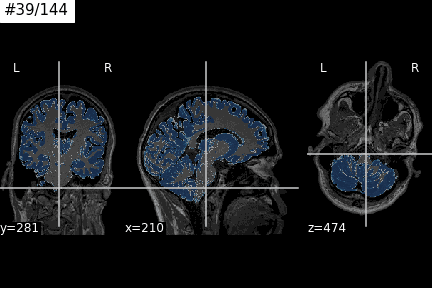

In [20]:
utils.qc_spm_segmentations(cohort, mni_space=False, show_wm=True, show_gm=False, cut_coords=None)

#### Image Validity Protocol

In order that the brain mask was well computed, we need to ensure that:

    1 - Review slices per plane
        1.1 - Is there white matter that is not segmented? 
        1.2 - Is there gray matter segmented inside the white matter mask? 
    2 - Does the MRI have any common artifacts? (e.g. inhomogeneity, etc...)
    3 - Does the MRI have low SNR?
    
Each MRI scan was analyzed with `3D Slicer v.5.0.3`.

## Radiomic features

SPM12 generates multiple tissue probability maps. Our interest is the `c2` mask which is the segmented white matter. Using NiBabel, we will convert all the maps to NumPy arrays and construct binary masks for white matter. From there, we will compute the radiomics feaatures using PyRadiomics.

In [20]:
import glob, json, csv, logging
from radiomics import featureextractor
import nibabel as nib
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

def save_radiomics_to_json(data):
    '''
    Saves the radiomic features in a JSON file
    
    data: OrderedDict
        Output of radiomic features stored in an OrderedDict.
    '''
    
    def default(obj):
        if type(obj).__module__ == np.__name__:
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return obj.item()
        raise TypeError('Unknown type:', type(obj))

    dumped = json.dumps(data, default=default)

    with open(os.path.join("outputs", "radiomics", COHORT_TYPE, "radiomicsOutput.json"), 'w') as f:
        json.dump(dumped, f)

def get_radiomics_json() -> dict:
    '''
    Return a dictionary containing the radiomics features original output.
    '''
    
    with open(os.path.join("outputs", "radiomics", COHORT_TYPE, "radiomicsOutput.json"), 'r') as f:
        return json.loads(json.load(f))
    
def compute_radiomics(cohort, force=False):
    '''
    Runs PyRadiomics to compute radiomic features.
    
    cohort: pd.DataFrame
        Cohort containing patients IDs and MRI file paths
        
    force: bool, optional
    '''
    
    # Instantiate the extractor
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.disableAllFeatures()
    extractor.enableFeatureClassByName("glcm")
    extractor.enableFeatureClassByName("glszm")
    extractor.enableFeatureClassByName("glrlm")
    
    # Ignore non-error logs
    logger = logging.getLogger("radiomics")
    logger.setLevel(logging.ERROR)
    
    # Initiate results dictionary
    radiomicsResults = {}
        
    # If a subject fails, add to "exclusion" array
    exclude = set() if not os.path.exists("exclusions.csv") else open_exclusions()
    
    # Create directory to save results
    folder = os.path.join("outputs", "radiomics", COHORT_TYPE)
    if not os.path.exists(folder):
        os.makedirs(os.path.join("outputs", "radiomics", COHORT_TYPE), exist_ok=True)
        
    file_exists = os.path.exists(os.path.join("outputs", "radiomics", COHORT_TYPE, "radiomicsOutput.json"))
    
    if file_exists and not force:
        return display(Markdown('Skipping computation of radiomics, use force=True to run anyway.'))
        
    else:
        
        # Loop through every subject
        for inputMask in tqdm(cohort["File name"]):
            masks = []
            affines = []
            subjectId = inputMask.split("/")[2]
            subId = int(subjectId.split("-")[1])
            visitId = inputMask.split("/")[3].split("-")[-1]
            exclusionId = f"{subId}|{visitId}"
            segmentationDirectory = os.path.join(
                *inputMask.replace("inputs", "outputs/pre_processing", 1).split("/")[1:-1]
            )

            # Get every mask per subject (c0 to c5)
            for segmentation in sorted(glob.glob(f"{segmentationDirectory}/c*PPMI*")):
                mask = nib.load(segmentation)
                affines.append(mask.affine)
                masks.append(mask.get_fdata())

            # Combine all masks in one array
            maskArray = np.array(masks)
            
            if len(maskArray)==0:
                continue

            # Get all indices (0 to 5)
            indices = np.argmax(maskArray, axis=0)

            # Replace classes that are not WM to 0
            indices[indices!=1] = 0.0
            indices = indices.astype(np.float64)

            # Save as NifTi
            new_mask = nib.Nifti1Image(indices, affine=affines[1]) 
            mask_path = os.path.join(segmentationDirectory, "wm.nii")
            nib.save(new_mask, os.path.join(segmentationDirectory, "wm.nii"))

            # Compute radiomic features and save to dict
            try:
                radiomicsResults[subjectId] = extractor.execute(inputMask, mask_path)
            except:
                subId = int(subjectId.split("-")[1])
                if subId not in exclude:
                    exclude.append(exclusionId)
                print(f"Error for subject, adding to exclusions list...")
                continue

            # Delete WM segmentation
            os.system(f"rm -rf {mask_path}")

            # Save exclusion file
            save_exclusions(exclude)

        # Save as JSON
        save_radiomics_to_json(radiomicsResults)
        
    # If radiomics errors occur, run back from cell reference
    if len(radiomicsResults) != len(cohort):
        return display(Markdown('[Due to radiomic computation errors, please run the notebook again from this cell (click me)](#Merge-all-dataframes-together)'))

**The PyRadiomics library may fail due to errors found in the MRI scan. If that is the case, the code will prompt you to run back the notebook from this [cell](#Merge-all-dataframes-together). Additionally, if the radiomic features already exist, you may need to use `force=True` to run the following cell again.**

In [21]:
compute_radiomics(cohort, force=True)

## ROI features

TODO: Use `Boutiques` to automate this process.

In [22]:
# Read CSV
roi_df = pd.read_csv(
    os.path.join("freesurfer", "ReferenceCohort", "volumes.csv")
)

# Keep ROIs
def combine_left_right_vol(df):
    '''
    Combines the Left and Right volumes into one column
    
    Parameters
    ----------
        df: ROI dataframe
    '''
    for column in df.columns:
        if "Left" in column:
            area = "-".join(column.split("-")[1:])
            left_area = f"Left-{area}"
            right_area = f"Right-{area}"
            df[area] = df[left_area] + df[right_area]
            df = df.drop(columns = [left_area, right_area])
    return df

ROI = [
    "PATNO",
    "Left-Putamen", "Right-Putamen", 
    "Right-Caudate", "Left-Caudate", 
    "Right-Thalamus-Proper", "Left-Thalamus-Proper", 
    "Left-Pallidum", "Right-Pallidum", 
    "Left-Cerebellum-White-Matter", "Right-Cerebellum-White-Matter", 
    "Left-Cerebellum-Cortex", "Right-Cerebellum-Cortex",
    "3rd-Ventricle", 
    "4th-Ventricle",
    "Insula",
    "Precentral Cortex",
    "Pons", "SCP", "Midbrain"
]

# Keep ROIs and merge volumes
roi_df = combine_left_right_vol(roi_df[ROI])

# Append output (stable/progr)
output_df = progr[["PATNO", "stable"]].append(stable[["PATNO", "stable"]])
output_df["stable"] = output_df["stable"].astype(int)
roi_df = roi_df.merge(output_df, on="PATNO").rename(columns={"stable":"output"})

# Feature selection

We will use two sets of features. The first set of features will be the top radiomic features using rMRMe with `k=7`. The second set of features will be Shu et al.'s original 7 features.

#### Create dataframe for mRMRe radiomic features

In [23]:
subjectIds = []
frames = []
output = []
radiomicsResults = get_radiomics_json()

# Collect subject IDs and radiomic features
for sub in radiomicsResults.keys():
    subjectIds.append(sub)
    frames.append(pd.DataFrame.from_dict(radiomicsResults[sub], orient='index').T)
    
radiomics_df = pd.concat(frames, keys=subjectIds)
radiomics_df = radiomics_df.loc[:, ~radiomics_df.columns.str.startswith('diagnostics')].reset_index()

# Append output to dataframe
for k in radiomics_df["level_0"]:
    subId = k.split("-")[1]
    output.append(1 if int(subId) in progr["PATNO"].values else 0)

# Add output column
radiomics_df["output"] = output

# Save to CSV
radiomics_df.drop(['level_0','level_1'], axis=1).to_csv(os.path.join('outputs', 'radiomics', COHORT_TYPE, 'features.csv'))

### rMRMe using R
The R script takes as input the number of top features to select, it can be executed in the following manner:

```
Rscript featureReduction.r [numberOfFeatures]

    numberOfFeatures: integer
    The number of top features to select in the mRMR algorithm (K).
```

In [24]:
if COHORT_TYPE == "Reference Cohort":
     !(Rscript code/scripts/featureReduction.r 7 reference)
elif COHORT_TYPE == "Multiple 3T Scanner Cohort":
    !(Rscript code/scripts/featureReduction.r 7 multiple)
elif COHORT_TYPE == "PD-state Cohort":
    !(Rscript code/scripts/featureReduction.r 7 pdstate)

Loading required package: mRMRe
Loading required package: survival
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: crayon
Succesfully computed top features, index available in: outputs/radiomics/Reference Cohort/featureIndex.csv

#### Create a dataframe for rMRMe features

In [25]:
# Get index of column features
index_df = pd.read_csv(os.path.join('outputs', 'radiomics', COHORT_TYPE, 'featureIndex.csv'))

# Keep important columns
columns = radiomics_df.drop(['level_0','level_1'], axis=1).columns
features = ["level_0"]

# Save features
for index in index_df.iloc[:,-1:].values.flatten():
    features.append(columns[index-1])

features.append("output")

# Save to DF
rmrme_df = radiomics_df[features]
rmrme_df = rmrme_df.rename(columns={"level_0":"PATNO"})
rmrme_df["PATNO"] = rmrme_df["PATNO"].map(lambda x: int(x.replace("sub-", "")))
rmrme_df.groupby("output").count()

,PATNO,original_glrlm_LongRunLowGrayLevelEmphasis,original_glcm_Idn,original_glcm_ClusterShade,original_glrlm_GrayLevelNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glcm_ClusterProminence,original_glcm_Imc2
output,,,,,,,,
0,72,72,72,72,72,72,72,72
1,72,72,72,72,72,72,72,72


### Original features used in Shu et al.

In the supplementary material, the authors share the 7 features selected. Since we do not have the A.K software to compute them, we will compute them manually using NumPy operations.

| Feature | Formula | Description | PyRadiomics |
| --- | :---: | :---: | :---: |
| Correlation_angle45_offset1 | $$-\sum_{ij} \dfrac{(i-u)(j-u)g(i, j)}{\sigma^2}$$ | Correlation measures the similarity of the grey levels in neighboring pixels, tells how correlated a pixel is to its neighbor over the whole image. Range = [-1 1]. Correlation is 1 or -1 for a perfectly positively or negatively correlated image. | Manual implementation |
| Inertia_AllDirection_offset4 | $$\sum_{ij} ((i-j)^2g(i, j))$$ | It reflects the clarity of the image and texture groove depth. The contrast is proportional to the texture groove, high values of the groove produces more clarity, in contrast small values of the groove will result in small contrast and fuzzy image. | [getContrastFeatureValue](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics.glcm.RadiomicsGLCM:~:text=is%20returned.-,getContrastFeatureValue,-()) |
| GLCMEntropy_AllDirection_offset1 | $$-\sum_{ij} g(i, j)\log_2(i,j)$$ | Entropy shows the amount of information of the image that is needed for the image compression. Entropy measures the loss of information or message in a transmitted signal and also measures the image information. | [getJointEntropyFeatureValue](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics.glcm.RadiomicsGLCM:~:text=getJointEntropyFeatureValue) |
| RunLengthNonuniformity_angle45_offset7 | $$\dfrac{1}{n_r}\sum_{j=1}^{M}(\sum_{i=1}^{N} p(i,j,\theta))^2$$ | The grey level run-length matrix (RLM) Pr(i, j, θ) is defined as the numbers of runs with pixels of gray level i and run length j for a given direction θ. RLMs is generated for each sample image segment having directions (0°,45°,90° &135°) | [getRunLengthNonUniformityFeatureValue](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics.glcm.RadiomicsGLCM:~:text=getRunLengthNonUniformityFeatureValue) |
| ShortRunEmphasis_angle0_offset7 | $$\dfrac{1}{n_r}\sum_{j=1}^{M}\sum_{i=1}^{N}\dfrac{p(i,j,\theta)}{i^2j^2}$$ | | [getShortRunLowGrayLevelEmphasisFeatureValue](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics.glcm.RadiomicsGLCM:~:text=getShortRunLowGrayLevelEmphasisFeatureValue) |
| HaralickCorrelation_angle90_offset4 | $$-\sum_{ij}\dfrac{(i,j)g(i,j)-u_t^2}{\sigma_t^2}$$ | Measures the degree of similarity of the gray level of the image in the row or column direction. Represents the local grey level correlation, the greater its value, the greater the correlation | [getCorrelationFeatureValue](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics.glcm.RadiomicsGLCM:~:text=getCorrelationFeatureValue()) |
| HaralickCorrelation_angle90_offset7 | $$-\sum_{ij}\dfrac{(i,j)g(i,j)-u_t^2}{\sigma_t^2}$$ | Measures the degree of similarity of the gray level of the image in the row or column direction. Represents the local grey level correlation, the greater its value, the greater the correlation | [getCorrelationFeatureValue](https://pyradiomics.readthedocs.io/en/latest/features.html#radiomics.glcm.RadiomicsGLCM:~:text=getCorrelationFeatureValue()) |


#### Create a dataframe for Shu et al features

In [26]:
shu_df = radiomics_df[["level_0", "original_glcm_Correlation", "original_glcm_Contrast", "original_glcm_JointEntropy", "original_glrlm_RunLengthNonUniformity", "original_glrlm_ShortRunLowGrayLevelEmphasis", "output"]]
shu_df = shu_df.rename(columns={"level_0":"PATNO"})
shu_df["PATNO"] = shu_df["PATNO"].map(lambda x: int(x.replace("sub-", "")))
shu_df.groupby("output").count()

,PATNO,original_glcm_Correlation,original_glcm_Contrast,original_glcm_JointEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis
output,,,,,,
0,72,72,72,72,72,72
1,72,72,72,72,72,72


## Machine Learning

In this section, we will implement the Machine Learning stack of (Shu et al)'s study.

### Normalization

The original study __does not share__ information on how the features were normalized. Since there are various scanners used in the cohort, we will implement a normalization technique found in [Automated Categorization of Parkinsonian Syndromes Using Magnetic Resonance Imaging in a Clinical Setting](https://pubmed.ncbi.nlm.nih.gov/33137232/).

(Chougar et al.) predict different subtypes of Parkinsonian syndromes by measuring regional volumes across 13 ROI's found within white matter, gray matter and ventricles. Two normalization techniques are implemented in the study, one aims to normally distribute the data while the second aims _"to harmonize data across scanners, reduce scanner-dependent effects in the images, and find a good trade-off between standard normal distribution and same distribution of the features in both cohorts."_

$$\dfrac{f - \mu_g,_s}{\sigma_g,_s}$$

where given a feature __f__ (any feature from any patient), group __g__ (stable or progressive) and a MRI scanner machine __s__, **μ<sub>g|s</sub>** and **σ<sub>g|s</sub>** are the mean and standard deviation of a group using the same scanner respectively. 

In (Shu et al.)'s study, data extracted from a brain mask helps build a good predictive model. Since (Chougar et al.) also use data extracted from brain masks, implementing the normalization technique may help improve our machine learning model.

In [27]:
def normalize(df, features):
    for scanner, df_group in df.groupby("Imaging Protocol"):
        for feature in features:
            # Compute mean and standard deviation
            mean = 0 if len(df_group) == 1 else df_group[feature].mean()
            std = 1 if len(df_group) == 1 else df_group[feature].std()
            
            # Apply transformation
            normalized = (df_group[feature] - mean)/std
            df.loc[df["Imaging Protocol"]==scanner, feature] = normalized

We need a util function to merge the imaging protocol to the features dataframe in order to normalize the data. We will implement the `merge_scanner_to_features_df` function that will do so.

In [28]:
def merge_scanner_to_features_df(df):
    '''
    Merge scanner used to features dataframe
        df: DatFrame
        -> Features dataframe
    '''
    # Keep important columns
    scanner_df = mri_df[["PATNO", "EVENT_ID", "Imaging Protocol"]]
    
    # Merge on PATNO and EVENT_ID
    scanner_df=cohort.merge(mri_df, on=["PATNO", "EVENT_ID"])
    scanner_df["Imaging Protocol"] = scanner_df["Imaging Protocol"].replace({'Siemens': 'SIEMENS'})
    
    # Drop duplicates
    scanner_df = scanner_df.drop_duplicates(subset="PATNO")
    
    # Merge features dataframe to scanner dataframe
    df = df.merge(scanner_df[["PATNO", "Imaging Protocol"]], on=["PATNO"])
    return df

### Model validation

We will validate the model using two cross-validation loops developed by Shu et al. and Chougar et al.

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import math
from sklearn import metrics

def bootstrap(df, clf, n_iterations = 100, n_size = int(len(df) * 0.50)):
    '''
    Bootstrapping implementation based on Shu et al.
    
    Parameters
        ----------
        df: DataFrame
            Dataframe with features, output and imaging protocol
        clf: sklearn.svm._classes.SVC
            Classifier (SVM)
        n_iterations : int, default 100
            Number of iterations, default is 100 as per Shu et al.'s study'
        n_size : int, default 0.5
            Size of split for each iteration, default is 0.5
        -> 
    '''
    
    # Performance array
    performance = []
    tprs = []
    aucs = []
    
    # Figure configuration
    fig, ax = plt.subplots(figsize=(6, 6))
    mean_fpr = np.linspace(0, 1, 100)
    
    # Start loop
    for i in tqdm(range(n_iterations)):
        
        # Sample training set
        train = resample(df, n_samples = 50, replace=False, random_state=i+1)

        # Sample test set
        trainPatno = set(train["PATNO"])
        testPatno = set(df["PATNO"]).difference(trainPatno)
        test = df[df["PATNO"].isin(testPatno)]

        # Get features and data split
        X_train = train
        y_train = train[train.columns[-2]]
        X_test = test
        y_test = test[test.columns[-2]]
        features = df.loc[:, ~df.columns.isin(['PATNO', 'output'])].columns

        # Normalize data
        normalize(X_train, features[:-1])
        normalize(X_test, features[:-1])
        
        X_train = X_train[train.columns[1:-2]]
        X_test = X_test[test.columns[1:-2]]

        # Train
        model = clf.fit(X_train, y_train)
        
        y_pred_proba = clf.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        
        # Display ROC
        viz = RocCurveDisplay.from_estimator(
            model,
            X_test,
            y_test,
            name=f"ROC fold {i}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # Save performance
        performanceDict = performance_report(model, i, X_train, X_test, y_train, y_test)
        performance.append(performanceDict)
        
    # Plot ROC curve
    display_roc_curve(aucs, tprs, mean_fpr, ax)
    
    # Save results
    jsonStr = json.dumps(performance)
    with open(f'outputs/performance/{COHORT_TYPE}/{MODEL_TYPE}_{FEATURE_TYPE}_{VALIDATION_TYPE}_performance.json', 'w') as f:
        json.dump(jsonStr, f)
    
    return model, performance

def cross_validation(df, clf, param_grid, n_splits=5, n_repeats=50):
    '''
    Cross-validation implementation based on Chougar et al.
    
    Parameters
    ----------
    df: DataFrame
        Dataframe with features, output and imaging protocol
    clf: sklearn.svm._classes.SVC
        Classifier (SVM)
    n_splits : int, default 5
        Number of folds, default is 5 as per Chougar et al.'s study'
    n_repeats : int, default 50
       Number of times cross-validator needs to be repeated, default is 50 as per Chougar et al.'s study'
    '''
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(6, 6))
    mean_fpr = np.linspace(0, 1, 100)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    # Normalize data
    normalize(df, df.columns[1:-2])
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(df_features[df_features.columns[1:-2]], df_features["output"], test_size=0.30)

    # Train
    gs = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    model = gs.fit(X_train, y_train)
    
    # Compute ROC for validation set
    y_pred_test = model.predict_proba(X_test)[::,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_test)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_test)
    
    performanceDict = performance_report(model, 0, X_train, X_test, y_train, y_test)
    performance.append(performanceDict)
    
    # Display ROC
    plt.title(f'{COHORT_TYPE} | {MODEL_TYPE} | {FEATURE_TYPE} | {VALIDATION_TYPE}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.savefig(f"outputs/performance/{COHORT_TYPE}/{FEATURE_TYPE}_CV.png")
    
    # Save results
    jsonStr = json.dumps(performance)
    with open(f'outputs/performance/{COHORT_TYPE}/{MODEL_TYPE}_{FEATURE_TYPE}_{VALIDATION_TYPE}_performance.json', 'w') as f:
        json.dump(jsonStr, f)
    
    return model, performance
        
        
def performance_report(clf, iteration, X_train, X_test, y_train, y_test):
    '''
    Outputs the performance of a model to a JSON file
    
    Parameters
    ----------
    clf: sklearn.svm._classes.SVC
        Classifier (SVM)
    iteration : int
        Iteration number
    X_train: DataFrame
        Dataframe of the training set features
    X_test: DataFrame
        Dataframe of the test set features
    y_train: DataFrame
        Dataframe of the training output column
    y_test: DataFrame
        Dataframe of the training output column
    '''
    
    # Save results to dictionary
    performanceDict = {}
    
    y_train_predict = clf.predict(X_train)
    y_test_predict = clf.predict(X_test)
    
    # Train set AUC
    y_pred_train = clf.predict_proba(X_train)[::,1]
    auc_train = metrics.roc_auc_score(y_train, y_pred_train)
    
    # Validation set AUC
    y_pred_test = clf.predict_proba(X_test)[::,1]
    auc_val = metrics.roc_auc_score(y_test, y_pred_test)
    
    # Sensitivity & Specificity
    tn_train, fp_train, fn_train, tp_train = metrics.confusion_matrix(y_train, y_train_predict).ravel()
    tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(y_test, y_test_predict).ravel()

    specificity_train = tn_train / (tn_train + fp_train)
    specificity_test = tn_test / (tn_test + fp_test)

    sensitivity_train = metrics.recall_score(y_train, y_train_predict)
    sensitivity_test = metrics.recall_score(y_test, y_test_predict)

    performanceDict = {
        "modelInfo": {"model": type(clf).__name__, "iteration": iteration},
        "auc_train": auc_train,
        "auc_val": auc_val,
        "specificity_train": specificity_train,
        "specificity_test": specificity_test,
        "sensitivity_train": sensitivity_train,
        "sensitivity_test": sensitivity_test
    }
    
    return performanceDict

def display_roc_curve(aucs, tprs, mean_fpr, ax):
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC curve - {COHORT_TYPE} - {FEATURE_TYPE} - {MODEL_TYPE}",
    )
    ax.axis("square")
    handles, labels = ax.get_legend_handles_labels()

    ax.legend(handles[-3:], labels[-3:])
    ax.get_figure()
    plt.savefig(f"outputs/performance/{COHORT_TYPE}/{FEATURE_TYPE}_{MODEL_TYPE}_bootstrap.png")
    plt.show()

def splitTrainingTestSets(df):
    '''
    Split the training and testing set
    
    Parameters:
    -----------
        df: Features dataframe
    '''

    stable_hys1_train, stable_hys1_test = train_test_split(stable[stable["NHY_x"]=="1"], train_size=25, test_size=7)
    progr_hys1_train, progr_hys1_test = train_test_split(progr[progr["NHY_x"]=="1"], train_size=25, test_size=7)
    
    stable_hys2_train, stable_hys2_test = train_test_split(stable[stable["NHY_x"]=="2"], train_size=25, test_size=15)
    progr_hys2_train, progr_hys2_test = train_test_split(progr[progr["NHY_x"]=="2"], train_size=25, test_size=15)
    
    train = pd.concat([stable_hys1_train, progr_hys1_train, stable_hys2_train, progr_hys2_train])
    test = pd.concat([stable_hys1_test, progr_hys1_test, stable_hys2_test, progr_hys2_test])
    
    return df[df['PATNO'].isin(train["PATNO"])], df[df['PATNO'].isin(test["PATNO"])]

def getModel(model):
    '''
    Helper function that returns a model and its parameters to tune.
    '''
    
    if model=="Linear SVM":
        param_grid = {}
        clf = SVC(kernel='linear', probability=True)
    
    elif model=="SVM":
        param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                      'kernel': ['linear', 'poly', 'rbf']} 
        clf = SVC(probability=True)

    elif model=="Decision Tree":
        param_grid = {'max_depth':[1,2,3,4,5,8,16,32], 
                      'max_leaf_nodes': list(range(2,20,1)), 
                      'min_samples_split': [2,3,4,5,8,12,16,20]}
        clf = DecisionTreeClassifier()

    elif model=="kNN":
        param_grid = {'leaf_size': list(range(1,50)), 
                      'n_neighbors': list(range(1,30)),
                      'p': [1, 2]}
        clf = KNeighborsClassifier()

    elif model=="Bayes":
        param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
        clf = GaussianNB()
        
    return clf, param_grid

def getData(feature):
    '''
    Helper function that returns a dataframe
    '''
    
    if feature=="Shu et al. features":
        df_features = merge_scanner_to_features_df(shu_df)
    elif feature=="rMRMe features":
        df_features = merge_scanner_to_features_df(rmrme_df)
    elif feature=="ROI features":
        df_features = merge_scanner_to_features_df(roi_df) 
    elif feature=="Experiment features":
        df_features = merge_scanner_to_features_df(experiement_df)
        
    # Convert values to float
    for column in df_features.columns[1:-2]:
        df_features[column] = df_features[column].astype(np.float64)
      
    # Convert Siemens to SIEMENS
    df_features.loc[df_features["Imaging Protocol"] == "Siemens", 'Imaging Protocol'] = "SIEMENS"
        
    return df_features

def displayResults(performance):
    '''
    Helper function that displays metrics of training and validation sets
    '''
    
    results = pd.DataFrame(columns=[f"Training Set", f"Validation Set"])
    
    # Compute average AUC, RSD, Sensitivity & Specificity
    auc_train = np.array([fold["auc_train"] for fold in performance])
    auc_test = np.array([fold["auc_val"] for fold in performance])
    
    sensitivity_train = np.array([fold["sensitivity_train"] for fold in performance]).mean()
    specificity_train = np.array([fold["specificity_train"] for fold in performance]).mean()
    
    sensitivity_test = np.array([fold["sensitivity_test"] for fold in performance]).mean()
    specificity_test = np.array([fold["specificity_test"] for fold in performance]).mean()
    
    rsd_train = (np.std(auc_train)/auc_train.mean()) * 100
    rsd_test = (np.std(auc_test)/auc_test.mean()) * 100
    
    results.loc["AUC"] = [auc_train.mean(), auc_test.mean()]
    results.loc["RSD"] = [rsd_train, rsd_test]
    results.loc["Sensitivity"] = [sensitivity_train, sensitivity_test]
    results.loc["Specificity"] = [specificity_train, specificity_test]
    
    return results

### Select features

As mentionned, we will train our model with three sets of features. Select which feature you would like to train the model with:

|     **Feature Type**     |                                          **Description**                                          |
|:-----------------------:|:-------------------------------------------------------------------------------------------------:|
| Shu et al. features       | Radiomic features used in Shu et al. via A.K software mapped using PyRadiomics.       |
| rMRMe features | Top 7 PyRadiomic features selected with the rMRMe R package. |
| ROI features | Volumetic features of 13 ROIs measured with FreeSurfer |

**NOTE: If this step is not completed, we will use the Shu et al. features by default**

In [31]:
question_features=widgets.RadioButtons(
    options=['Shu et al. features', 'rMRMe features', 'ROI features', 'Experiment features'],
    value=None,
    description='Select features:',
    disabled=False)

def feature_prompt(sender): 
    FEATURE_TYPE = question_features.value
    print('Selected features: ' + FEATURE_TYPE)
        
question_features.observe(feature_prompt, names=['f_value'])
question_features

RadioButtons(description='Select features:', options=('Shu et al. features', 'rMRMe features', 'ROI features',…

### Select validation technique

Select which validation technique to use when training the model.

|     **Validation techinque**     |                                          **Description**                                          |
|:-----------------------:|:-------------------------------------------------------------------------------------------------:|
| Bootstrapping approach       | Shu et al.'s bootstrapping approach to further validate the stability of the model. The RSD was computed to quantify this stability, where lower RSD values correspond to higher stability. This was done 100 times with a train/test split of 0.5. |
| Cross-validation approach | Chougar et al.'s cross-validation approach that includes two nested loops: an outer loop with repeated stratified random splits with 50 repetitions evaluating the classification performances and an inner loop with 5-fold cross-validation used to optimise the hyperparameters of the algorithms. |

**NOTE: If this step is not completed, we will use the Bootstrapping approach by default**

In [32]:
question_validation=widgets.RadioButtons(
    options=['Bootstrapping approach', 'Cross-validation approach'],
    value=None,
    description='Select validation technique:',
    disabled=False)

def validation_prompt(sender): 
    VALIDATION_TYPE = question_validation.value
    print('Selected validation: ' + VALIDATION_TYPE)
        
question_validation.observe(validation_prompt, names=['value'])
question_validation

RadioButtons(description='Select validation technique:', options=('Bootstrapping approach', 'Cross-validation …

Selected validation: Bootstrapping approach


### Select model

Select which algorithm to train.

|     **Model**     | **Description**| **Grid Search**|
|:------------------:|:------------:|----------------:|
| Linear SVM       | Shu et al. used this algorithm to train their model | No
| SVM | Tunes the C, gamma and kernel type | Yes
| Decision Tree | Tunes the max_depth, max_leaf_nodes and min_samples_split | Yes
| kNN | Tunes the leaf_size, number of neighbors and p | Yes
| Gaussian Naive Bayes | Tunes the var_smooothing | Yes

**NOTE: If this step is not completed, we will use the Linear SVM model by default**

In [33]:
question_model=widgets.RadioButtons(
    options=['Linear SVM', "SVM", "Decision Tree", "kNN", "Bayes"],
    value=None,
    description='Select model:',
    disabled=False)

def model_prompt(sender): 
    MODEL_TYPE = question_model.value
    print('Selected model: ' + MODEL_TYPE)
        
question_model.observe(model_prompt, names=['value'])
question_model

RadioButtons(description='Select model:', options=('Linear SVM', 'SVM', 'Decision Tree', 'kNN', 'Bayes'), valu…

Selected model: Linear SVM


## Model training using Scikit-Learn

### Performance

We will report the AUC and relative standard deviation) RSD of the SVM constructed.

$$RSD = \dfrac{\sigma_{AUC}}{\mu_{AUC}} x 100$$

where σ<sub>AUC</sub> and µ<sub>AUC</sub> are the standard deviation and mean of the 100 AUC values, respectively. 

Training the following:
--------------------------------------------------
COHORT: Reference Cohort
FEATURES: Shu et al. features
MODEL TYPE: Linear SVM
VALIDATION TECHNIQUE: Bootstrapping approach
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

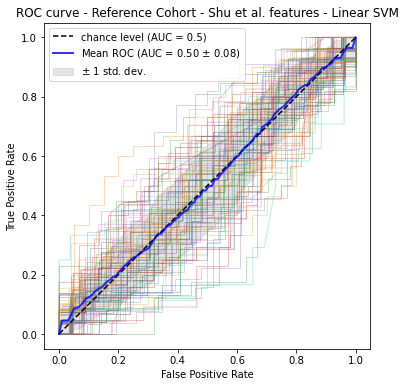

AUC of test set: 0.5227272727272727


,Training Set,Validation Set
AUC,0.452831,0.503318
RSD,31.766381,16.191631
Sensitivity,0.570224,0.456446
Specificity,0.608229,0.491385


In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

VALIDATION_TYPE = "Bootstrapping approach" if question_validation.value is None else question_validation.value
MODEL_TYPE = "Linear SVM" if question_model.value is None else question_model.value
FEATURE_TYPE = "Shu et al. features" if question_features.value is None else question_features.value

# Define features
df_features = getData(FEATURE_TYPE)

# Modify scanners
df_features.loc[df_features["Imaging Protocol"] == 'Philips Medical Systems|PMOD Technologies', 'Imaging Protocol'] = 'Philips Medical Systems'

# Define model
clf, param_grid = getModel(MODEL_TYPE)

# Split dataset
if COHORT_TYPE=="Reference Cohort" and (FEATURE_TYPE=="Shu et al. features" or FEATURE_TYPE=="rMRMe features") and MODEL_TYPE=="Linear SVM" and VALIDATION_TYPE=="Bootstrapping approach":
    train, test = splitTrainingTestSets(df_features)
else:
    train, test = train_test_split(df_features, test_size=0.3)

# Train
print(f"\033[1mTraining the following:\n{'-'*50}\nCOHORT: {COHORT_TYPE}\nFEATURES: {FEATURE_TYPE}\nMODEL TYPE: {MODEL_TYPE}\nVALIDATION TECHNIQUE: {VALIDATION_TYPE}\n{'-'*50}\033[0m")
trainedClf, performance = bootstrap(train, clf) if VALIDATION_TYPE=="Bootstrapping approach" else cross_validation(df_features, clf, param_grid)

# Test
normalize(test, test.columns[1:-2])
X_test = test[test.columns[1:-2]]
y_test = test["output"]
fpr, tpr, threshold = roc_curve(y_test, trainedClf.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)


print(f"\033[1mAUC of test set: {roc_auc}\033[0m")
displayResults(performance)

## Run all configurations

In [71]:
FEATURES = ["Shu et al. features", "Experiment features", 'rMRMe features', 'ROI features']
MODELS = ["Linear SVM", "SVM", "Decision Tree", "kNN", "Bayes"]
TECHINIQUES=["Bootstrapping", "Cross-validation"]

for val in TECHINIQUES:
    VALIDATION_TYPE = val
    
    for model in MODELS:
        MODEL_TYPE = model
        clf, param_grid = getModel(model)
        
        for feature in FEATURES:
            FEATURE_TYPE = feature
            df_features = getData(feature)
            
            # Get train/test
            if COHORT_TYPE=="Reference Cohort" and (FEATURE_TYPE=="Shu et al. features" or FEATURE_TYPE=="rMRMe features") and MODEL_TYPE=="Linear SVM" and VALIDATION_TYPE=="Bootstrapping approach":
                train, test = splitTrainingTestSets(df_features)
            else:
                train, test = train_test_split(df_features, test_size=0.3)
                
            # Run
            print(f"\033[1mTraining the following:\n{'-'*50}\nCOHORT: {COHORT_TYPE}\nFEATURES: {feature}\nMODEL TYPE: {model}\nVALIDATION TECHNIQUE: {val}\n{'-'*50}\033[0m")
            trainedClf, performance = bootstrap(train, clf) if VALIDATION_TYPE=="Bootstrapping" else cross_validation(df_features, clf, param_grid)
                
            # Test
            normalize(test, test.columns[1:-2])
            X_test = test[test.columns[1:-2]]
            y_test = test["output"]
            fpr, tpr, threshold = roc_curve(y_test, trainedClf.predict(X_test))
            roc_auc = metrics.auc(fpr, tpr)
            print(displayResults(performance))
            print(f"\n\033[1mAUC of test set: {roc_auc}\033[0m\n")

## Feature analysis

In this section, we will analyze the features extracted using mRMRe and the features selected in Shu et al.

#### Create a dataframe to analyse scanners in the cohort

In [208]:
scanner_df = mri_df[["PATNO", "EVENT_ID", "Imaging Protocol", "Slice Thickness", "Field Strength"]]
scanner_df=cohort.merge(mri_df, on=["PATNO", "EVENT_ID"])
scanner_df["Imaging Protocol"] = scanner_df["Imaging Protocol"].replace({'Siemens': 'SIEMENS'})
scanner_df = scanner_df.drop_duplicates(subset="PATNO")
scanner_df.groupby("Imaging Protocol").count()

,PATNO,EVENT_ID,Description_x,File name,Sex,Age,Description_y,Slice Thickness,Field Strength
Imaging Protocol,,,,,,,,,
SIEMENS,144,144,144,144,144,144,144,144,144
